<a href="https://colab.research.google.com/github/umbertogagl97/Tesi/blob/main/scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Init**

##Import ART

In [2]:
#importa ART
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.2 MB 24.5 MB/s 
     |████████████████████████████████| 3.3 MB 43.9 MB/s 
     |████████████████████████████████| 26.3 MB 1.6 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


## Import librerie

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

from torchvision.transforms.functional import InterpolationMode

import cv2
from google.colab.patches import cv2_imshow
import os

##Check device


In [4]:
print(torch.__version__)
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:',device)

1.10.0+cu111
device: cpu


##Transforms

In [5]:
data_transform_test= transforms.Compose([transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
transf_load= transforms.Compose([transforms.ToTensor()])
transf_init=transforms.Resize(size=(500,500),interpolation=InterpolationMode.NEAREST)

##path

In [6]:
path_model="/content/GreenBit"

# **Creazione modello**


##Load model pre-trained

In [7]:
model = models.vgg19(pretrained=True,progress=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

##Aggiunta classificatore

In [8]:
model.classifier[6]=nn.Linear(4096,2)

##Load pesi

In [9]:
if device.type=='cpu': model.load_state_dict(torch.load(path_model,map_location=torch.device('cpu')))
else: model.load_state_dict(torch.load(path_model))

##Creazione classificatore ART Pytorch



In [10]:
from art.estimators.classification import PyTorchClassifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(0,1),
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.classifier.parameters(),lr=1e-5),
    input_shape=(3, 224, 224),
    nb_classes=2
)

#**Test function**

In [12]:
def test_average(classifier,input,transf_init):
  '''
  classifier: classifier wrapper ART
  input: tensor 1x3xnxm 
  return: pred: classe predetta, probabilities, values
  '''

  def calc_size(n):
    '''
    n: int 
    return: 80% of n
    '''
    return tuple(int(np.ceil(i * (80/100))) for i in n)

  preds=[]
  prob=nn.Softmax(dim=0)
  
  n=input.shape
  n_mod=calc_size(n[2:4])
  crop_transform=transforms.TenCrop((n_mod[0],n_mod[1]))
  crops=crop_transform(input)
  live=0
  spoof=0
  for crop in crops:
    crop=data_transform_test(crop) #resize 224
    outputs = classifier.predict(crop)
    live+=outputs[0][0]
    spoof+=outputs[0][1]
  live=live/10
  spoof=spoof/10
  values=[live,spoof]
  predicted=np.argmax(values)
  probabilities=prob(torch.Tensor(values)).numpy()

  return predicted,probabilities,values

#**Execute**

##images from drive

###link google drive

In [1]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [23]:
#path cartella con immagini da testare
path_images="/content/gdrive/MyDrive/prova"

In [24]:
directory = os.listdir(path_images)
for input in directory:
  img=cv2.imread(path_images+'/'+input)
  img=(img-np.min(img))/(np.max(img)-np.min(img))
  img_t=torch.Tensor(img.transpose(2,0,1)).unsqueeze_(0)
  print(test_average(classifier,img_t,transf_init))

(0, array([0.7222574 , 0.27774262], dtype=float32), [0.691153833270073, -0.2645328387618065])
(0, array([0.74      , 0.26000005], dtype=float32), [0.8643777787685394, -0.18159057646989823])


##single image

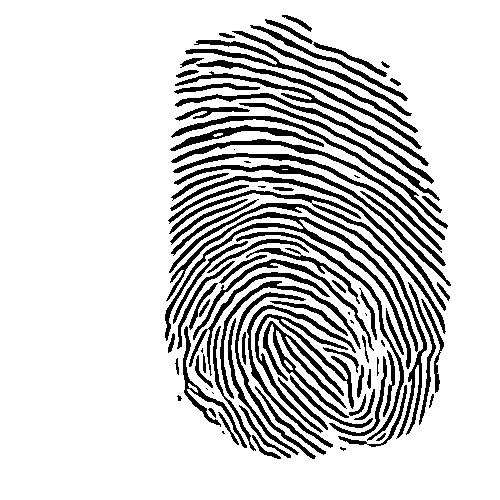

(0, array([0.7222574 , 0.27774262], dtype=float32), [0.691153833270073, -0.2645328387618065])


In [20]:
path_image="img.png" #path singola immagine caricata su colab
img=cv2.imread(path_image)
cv2_imshow(img)
img=(img-np.min(img))/(np.max(img)-np.min(img))
img_t=torch.Tensor(img.transpose(2,0,1)).unsqueeze_(0)
print(test_average(classifier,img_t,transf_init))
#primo valore: 0 Live, 1 Spoof
#secondo valore: probabilità per le due classi
#terzo valore: uscita del modello